In [1]:
#This is a demonstration notebook that can be used to query the WOD instance. 
#You can run the cells by pressing shift + enter
#Please run the first few cells in order for the user input widgets to appear.

In [2]:
#Fill in your token that you have received via Blue-Cloud between the ''
Token = ''

In [3]:
#Importing the required packages
import requests
import json
import xarray as xr
import datetime
from ipywidgets import interact, widgets, interactive
from IPython.display import Javascript, display
import pandas as pd

In [4]:
#This retrieves the available parameters from the footprint.
responseinfo = requests.get("https://beacon-wod.maris.nl/api/datasets/footprint", headers = {'Authorization' : f'Bearer {Token}'}) 
open('Footprint_WOD.json', 'wb').write(responseinfo.content)
with open('Footprint_WOD.json', 'r') as f:
    data = json.load(f)

pd.set_option('display.max_rows', 500)
attributes = pd.DataFrame.from_dict(data['unique_column_attributes'], orient='index')
attributes.reset_index(level=0, inplace=True)
attributes = attributes.sort_values('index', ascending=True, key=lambda col: col.str.lower())
params = attributes['index'].to_numpy()

In [5]:
#In the widgets below, please input your filters and then press "Create indicators" to run the notebook
def f(parameter, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, mintemp, maxtemp):
    return parameter, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, mintemp, maxtemp

w = interactive(f, parameter = params, minlon = (-180, 180, 1), maxlon = (-180, 180, 1), minlat = (-90, 90, 1), maxlat = (-90, 90, 1), mindepth = widgets.IntSlider(min = 0, max = 5000, value = 0), maxdepth = widgets.IntSlider(min = 0, max = 5000, value = 10), mintemp = widgets.DatePicker(description='Start date:', value = datetime.date(2010, 1, 1)), maxtemp = widgets.DatePicker(description='End date:', value = datetime.date(2024, 1, 1)))

display(w)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

button = widgets.Button(description = "Create indicators")
button.on_click(run_all)
display(button)

interactive(children=(Dropdown(description='parameter', options=('Absol_Humidity', 'Access_no', 'Alkalinity', …

Button(description='Create indicators', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
#Storing the chosen filters in the correct terms
parameter = w.kwargs['parameter']
mintemp = w.kwargs['mintemp']
maxtemp = w.kwargs['maxtemp']
minlon = w.kwargs['minlon']
maxlon = w.kwargs['maxlon']
minlat = w.kwargs['minlat']
maxlat = w.kwargs['maxlat']
mindepth = w.kwargs['mindepth']
maxdepth = w.kwargs['maxdepth'] 

In [17]:
#Fixed fields
unit = attributes.loc[attributes['index'] == parameter]['units'].iloc[0]
dateref = datetime.date(1770, 1, 1) #Days since 1770
mintemporal = (mintemp - dateref).days #Days since 1770
maxtemporal = (maxtemp - dateref).days #Days since 1770
regionname = f'[{minlat},{minlon}],[{maxlat},{maxlon}]' 

In [18]:
#Query body based on input fields
#You can add other query_parameters and filters to suit your needs.
def query(parameter, mintemporal, maxtemporal, mindepth, maxdepth, minlon, maxlon, minlat, maxlat):
    body = {
        "query_parameters": [
            {
                "column_name": parameter,
                "alias": parameter
            },
            {
                "column_name": "time",
                "alias": "TIME"
            },
            {
                "column_name": "z",
                "alias": "DEPTH"
            },
            {
                "column_name": "lon",
                "alias": "LONGITUDE"
            },
            {
                "column_name": "lat",
                "alias": "LATITUDE"
            },
            {
                "column_name": "dataset",
                "alias": "DATASET"
            },
            {
                "column_name": "WOD_cruise_identifier",
                "alias": "cruise-identifier"
            },
            {
                "column_name": "wod_unique_cast",
                "alias": "cast"
            },
            {
                "column_name": "WMO_ID",
                "alias": "WMO_ID"
            }
        ],
        "filters": [
            {
              "for_query_parameter": "TIME",
              "min": mintemporal,
              "max": maxtemporal
            },
            {
              "for_query_parameter": "DEPTH",
              "min": mindepth,
              "max": maxdepth
            },
            {
              "for_query_parameter": "LONGITUDE",
              "min": minlon,
              "max": maxlon
            },
            {
              "for_query_parameter": "LATITUDE",
              "min": minlat,
              "max": maxlat
            }
        ],
        "output": {
            "format": "netcdf"
        }}
    return body

#You can add a filter for the parameter that your are querying in order to remove faulty outliers.
#             {
#               "for_query_parameter": parameter,
#               "min": -2,
#               "max": 40
#             }

#Examples of other relevant information to include.
#             {
#             "column_name": "country",
#             "alias": "country"
#             }

#You can add a filter for strings as well like this.
#             {
#               "for_query_parameter": "country",
#               "eq": "UNITED STATES"
#             }

query = query(parameter, mintemporal, maxtemporal, mindepth, maxdepth, minlon, maxlon, minlat, maxlat)

In [19]:
#This is the post request that is sent to Beacon with the above specified body.
response = requests.post("https://beacon-wod.maris.nl/api/query", json.dumps(query), headers = {
    'Authorization' : f'Bearer {Token}',
    'Content-type': 'application/json'
})

if response.status_code == 204:
    print('No data has been found for your query, please update your input fields above and run the notebook again.')
elif response.status_code != 200:
    print(response.text)

In [20]:
#It will create a Netcdf file in your directory with the name based on your filters.
#Output is shown here in a dataframe
open(f'WOD_{parameter}_{regionname}_{mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")}_[{mindepth}-{maxdepth}m].nc', 'wb').write(response.content)
df = xr.open_dataset(f'WOD_{parameter}_{regionname}_{mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")}_[{mindepth}-{maxdepth}m].nc').to_dataframe()
df

,dataset_id,Chlorophyll,TIME,DEPTH,LONGITUDE,LATITUDE,DATASET,cruise-identifier,cast,WMO_ID
INSTANCE,,,,,,,,,,
0,12988160,0.0000,88399.101579,4.084692,65.099998,20.676001,profiling float,US034068,15210111,5903586
1,12988160,0.0000,88399.101579,5.774199,65.099998,20.676001,profiling float,US034068,15210111,5903586
2,12988160,0.3066,88399.101579,7.563074,65.099998,20.676001,profiling float,US034068,15210111,5903586
3,12988160,0.0000,88399.101579,7.761837,65.099998,20.676001,profiling float,US034068,15210111,5903586
4,12988160,0.0000,88399.101579,9.749456,65.099998,20.676001,profiling float,US034068,15210111,5903586
...,...,...,...,...,...,...,...,...,...,...
473523,18059494,0.0000,92014.677746,5.845194,32.889313,75.609322,glider,NO005698,21232044,6801614
473524,18059494,0.0476,92014.677746,7.049400,32.889313,75.609322,glider,NO005698,21232044,6801614
473525,18059494,0.0000,92014.677746,8.096560,32.889313,75.609322,glider,NO005698,21232044,6801614


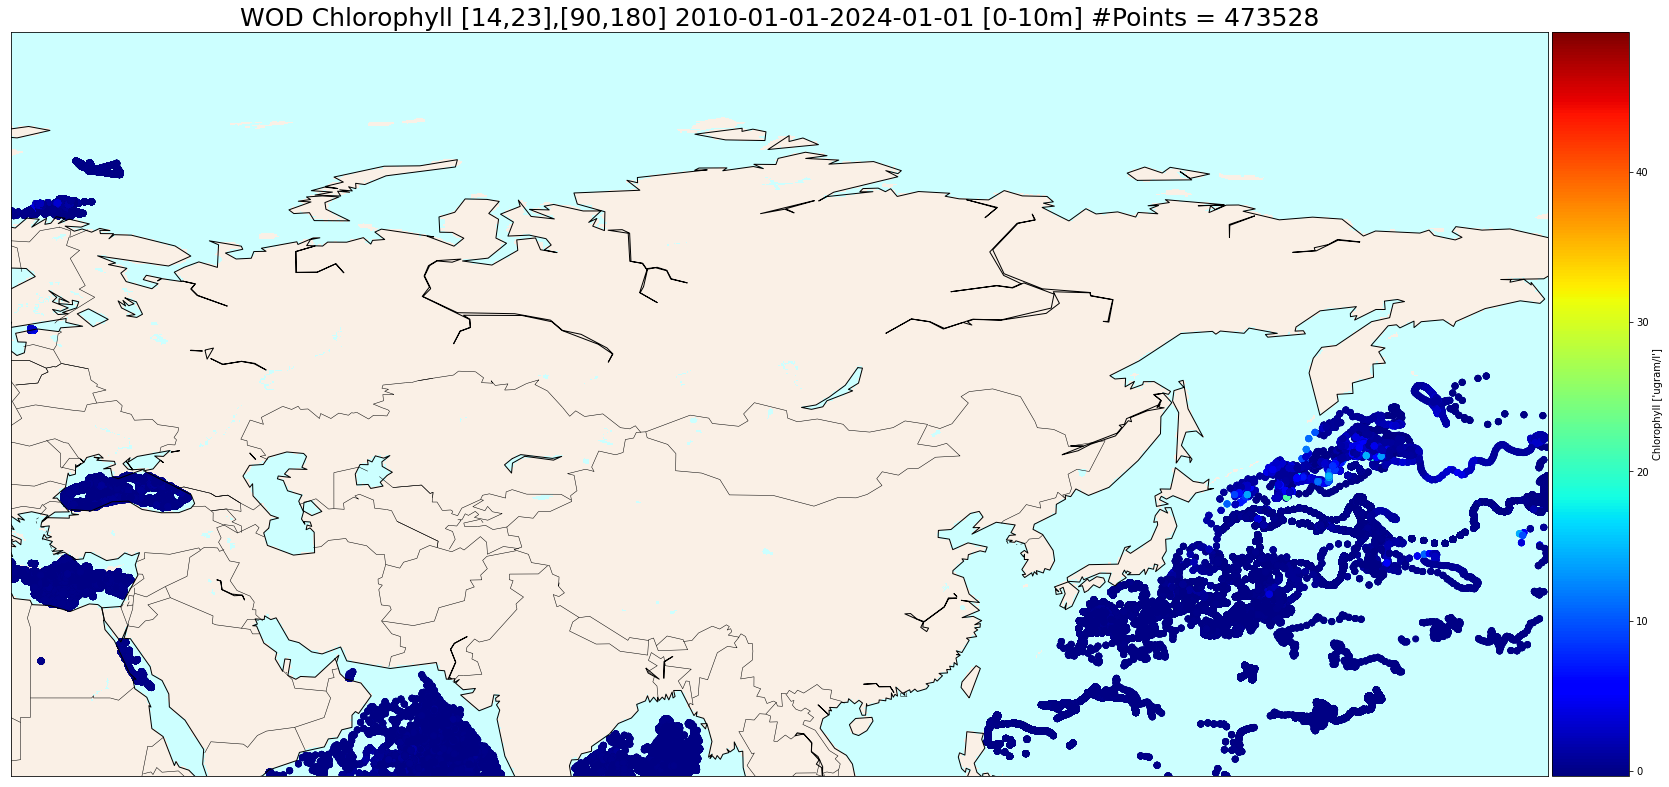

In [21]:
#Plotting of results, if there are alot of measurements, it may take quite some time (+-5 min)
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(1, figsize = (29, 19))

# Creating Basemap
m = Basemap(projection = 'cyl', llcrnrlon = minlon, llcrnrlat = minlat, urcrnrlon = maxlon, urcrnrlat = maxlat, resolution = 'c') 
m.drawlsmask(land_color = 'Linen', ocean_color = '#CCFFFF'); # can use HTML names or codes for colors
m.drawcoastlines()
m.drawcountries()

# Plot points
sc = m.scatter(df['LONGITUDE'], df['LATITUDE'], latlon = True, c = df[f'{parameter}'], cmap = plt.cm.jet)

plt.title(f'WOD {parameter} {regionname} {mintemp.strftime("%Y-%m-%d")}-{maxtemp.strftime("%Y-%m-%d")} [{mindepth}-{maxdepth}m] #Points = {len(df)}', fontsize = 25)

# Colorbar positioning
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.05)
plt.colorbar(sc, cax = cax, label = f'{parameter} {unit}');